In [1]:
%pip install scikit-image --quiet
n = 7
nq = 5
thresholds = 0.25
contrast = 95
tol = 7


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


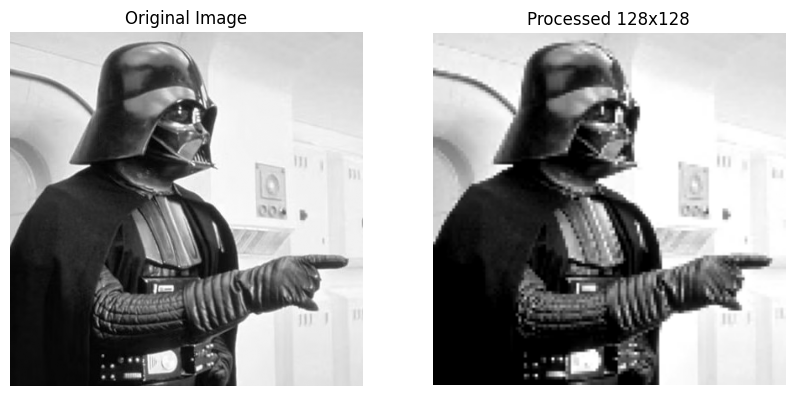

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.transform import resize


# Load a grayscale image (or convert to grayscale)
img = Image.open('/workspaces/AQA/images/Edge-Test-1.jpg').convert('L')
arr = np.array(img, dtype=np.float32) / 255.0  # Use float32 to save memory
contrast_low = 100-contrast    # Lower percentile for initial stretch
contrast_high = contrast  # Upper percentile for initial stretch
final_low = contrast_low+tol     # Lower percentile for final stretch
final_high = contrast_high-tol    # Upper percentile for final stretch

# Contrast stretching in-place
p2, p98 = np.percentile(arr, (contrast_low, contrast_high))
arr[:] = np.interp(arr, (p2, p98), (0, 1))

# Edge-preserving enhancement in-place
blurred = gaussian_filter(arr, sigma=0.5)
arr += 0.8 * (arr - blurred)
np.clip(arr, 0, 1, out=arr)

# Resize (float32)
arr = resize(arr, (2**n, 2**n), order=3, anti_aliasing=False, mode='reflect').astype(np.float32)

# Final contrast adjustment in-place
p5, p95 = np.percentile(arr, (final_low, final_high))
arr[:] = np.interp(arr, (p5, p95), (0, 1))
# Display the processed input image
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.array(img), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(arr, cmap='gray')
plt.title('Processed {}x{}'.format(2**n, 2**n))
plt.axis('off')
plt.show()

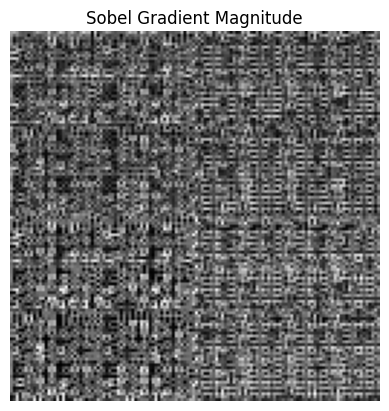

Gradient min: 0.0 max: 4.4271502 mean: 1.6409589


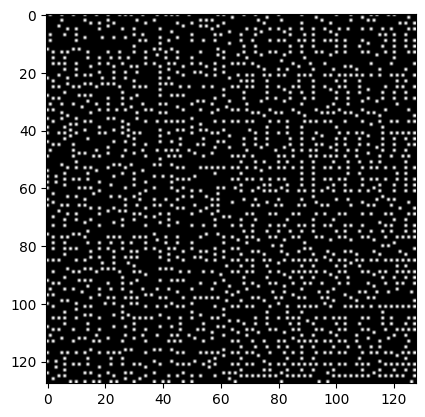

In [3]:
# Classical simulation of Sobel on the FRQI state (using statevector)
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector

# Build FRQI statevector via a circuit
pos_qubits = 2 * n
qr_pos = QuantumRegister(pos_qubits, 'pos')
qr_col = QuantumRegister(1, 'color')
qc = QuantumCircuit(qr_pos, qr_col)
# Initialize position in uniform superposition
qc.h(qr_pos)
# Controlled rotations to encode intensities
flat_arr = arr.flatten()
ctrl_strings = [format(i // (2**n), f'0{n}b') + format(i % (2**n), f'0{n}b') for i in range(2**(2*n))]
flip_indices = [[j for j, bit in enumerate(ctrl_string) if bit == '0'] for ctrl_string in ctrl_strings]
for i, pixel_val in enumerate(flat_arr):
    if pixel_val == 0 or pixel_val == 1:
        continue  # Skip trivial rotations
    theta = np.arccos(np.clip(pixel_val, 0, 1))
    angle = 2 * theta
    flips = flip_indices[i]
    for j in flips:
        qc.x(qr_pos[j])
    qc.mcry(angle, list(range(pos_qubits)), pos_qubits)
    for j in flips:
        qc.x(qr_pos[j])
# Simulate statevector of FRQI image
sv = Statevector.from_instruction(qc)

# Extract amplitude for each basis state where color qubit is 1
sv_data = np.array(sv.data)
amps1 = []
for i in range(2**(2*n)):
    idx = 2*i + 1  # color qubit is the least significant bit
    amps1.append(np.abs(sv_data[idx]))
amps1 = np.array(amps1) * (2**n)
img_frqi = amps1.reshape((2**n, 2**n)).astype(float)


# Classical Sobel gradients on the decoded image
from scipy import signal
Gx = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
Gy = np.array([[1, 2,  1],[0,0, 0],[-1,-2,-1]])
img_frqi = img_frqi.astype(np.float32)
gx = signal.convolve2d(img_frqi, Gx, mode='same', boundary='symm').astype(np.float32)
gy = signal.convolve2d(img_frqi, Gy, mode='same', boundary='symm').astype(np.float32)
g = np.hypot(gx, gy, dtype=np.float32)

plt.imshow(g, cmap='gray')
plt.title('Sobel Gradient Magnitude')
plt.axis('off')
plt.show()
print("Gradient min:", g.min(), "max:", g.max(), "mean:", g.mean())

# Add non-maximum suppression and increase threshold
from scipy.ndimage import maximum_filter
g_max = maximum_filter(g, size=3)
threshold = thresholds* g.max()  # Increased from 0.1 for thinner edges
edges_classical =((g > threshold) & (g == g_max)).astype(float)

plt.imshow(edges_classical, cmap='gray')


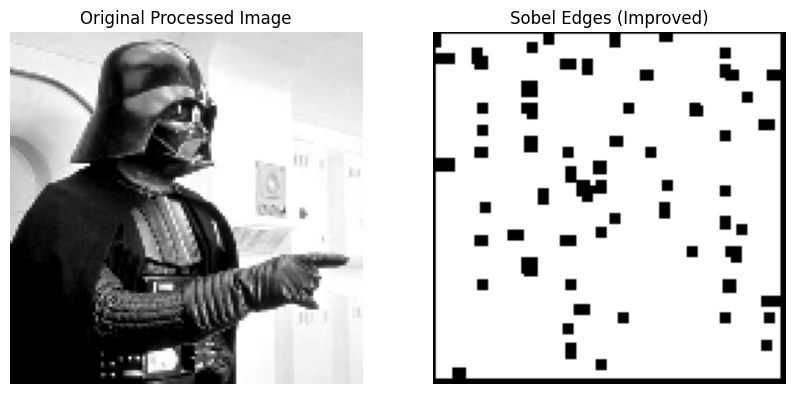

In [4]:
# Classical Sobel on original image with comparison
# Classical Sobel on original image with improved edges
"""
arr_blur = gaussian_filter(arr, sigma=0.7)
gx_orig = signal.convolve2d(arr_blur, Gx, mode='same', boundary='symm')
gy_orig = signal.convolve2d(arr_blur, Gy, mode='same', boundary='symm')
g_orig = np.hypot(gx_orig, gy_orig)
from scipy.ndimage import binary_closing, binary_dilation
g_max = maximum_filter(g_orig, size=3)
"""
from scipy.ndimage import binary_closing, binary_dilation

edges_post = binary_closing(edges_classical, structure=np.ones((3,3)), iterations=2)
edges_post = binary_dilation(edges_post, structure=np.ones((2,2)), iterations=1)
"""
edges_orig = (g_orig > threshold).astype(float)
edges_orig = binary_closing(edges_orig, structure=np.ones((3,3)), iterations=2)
edges_orig = binary_dilation(edges_orig, structure=np.ones((2,2)), iterations=1)
"""
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(arr, cmap='gray')
plt.title('Original Processed Image')
plt.axis('off')

plt.subplot(122)
#plt.imshow(edges_orig, cmap='gray')
plt.imshow(edges_post, cmap='gray')
plt.title('Sobel Edges (Improved)')
plt.axis('off')
plt.show()

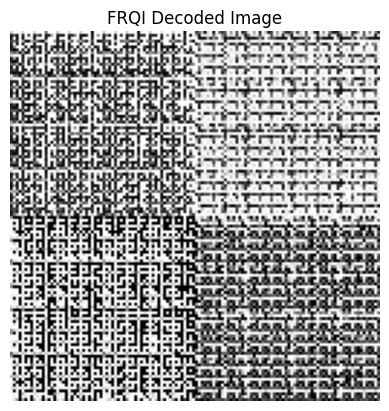

In [5]:
plt.imshow(img_frqi, cmap='gray')
plt.title('FRQI Decoded Image')
plt.axis('off')
plt.show()


=== Pre-Aer Simulation Check ===
Input image shape: (32, 32)
Input image stats: 0.0 1.0 0.555491
Circuit parameters:
- Total qubits: 11
- Angle range: 0.028 to 1.543
- Number of controlled rotations: 1024


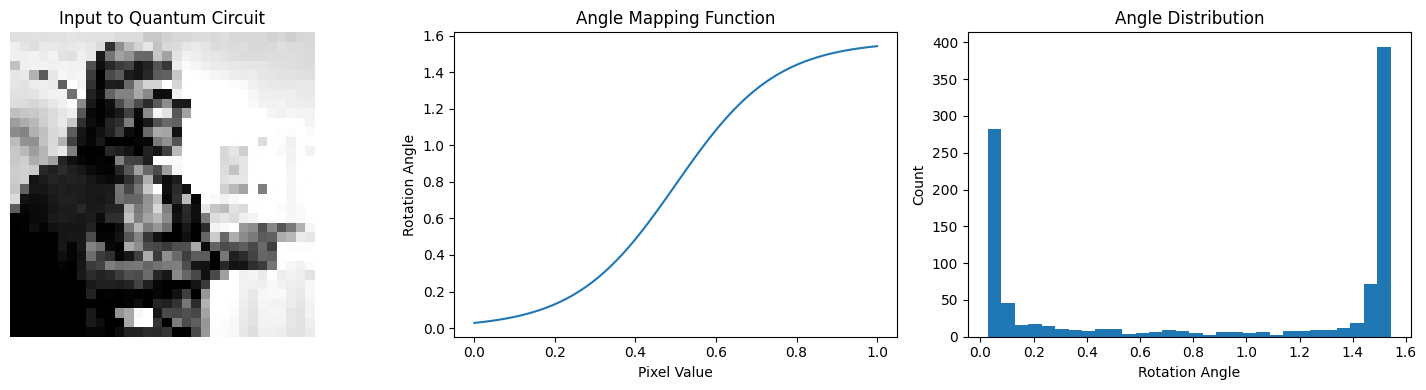

In [6]:
n=nq
arr = resize(arr, (2**n, 2**n), order=3, anti_aliasing=False, mode='reflect')
pos_qubits = 2 * n
# Add this right before the Aer simulation cell
print("\n=== Pre-Aer Simulation Check ===")
print("Input image shape:", arr.shape)
print("Input image stats:", arr.min(), arr.max(), arr.mean())
print("Circuit parameters:")
print(f"- Total qubits: {pos_qubits + 1}")
print(f"- Angle range: {(np.tanh(-0.5 * 4) + 1) * (np.pi/4):.3f} to {(np.tanh(0.5 * 4) + 1) * (np.pi/4):.3f}")
print(f"- Number of controlled rotations: {2**(2*n)}")

# Visualize the quantum encoding parameters
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(arr.reshape((2**n, 2**n)), cmap='gray')
plt.title('Input to Quantum Circuit')
plt.axis('off')

# Plot the angle mapping function
x = np.linspace(0, 1, 100)
theta = [(np.tanh((val - 0.5) * 4) + 1) * (np.pi/4) for val in x]
plt.subplot(132)
plt.plot(x, theta)
plt.title('Angle Mapping Function')
plt.xlabel('Pixel Value')
plt.ylabel('Rotation Angle')

# Show angle distribution
angles = [(np.tanh((val - 0.5) * 4) + 1) * (np.pi/4) for val in arr.flatten()]
plt.subplot(133)
plt.hist(angles, bins=30)
plt.title('Angle Distribution')
plt.xlabel('Rotation Angle')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

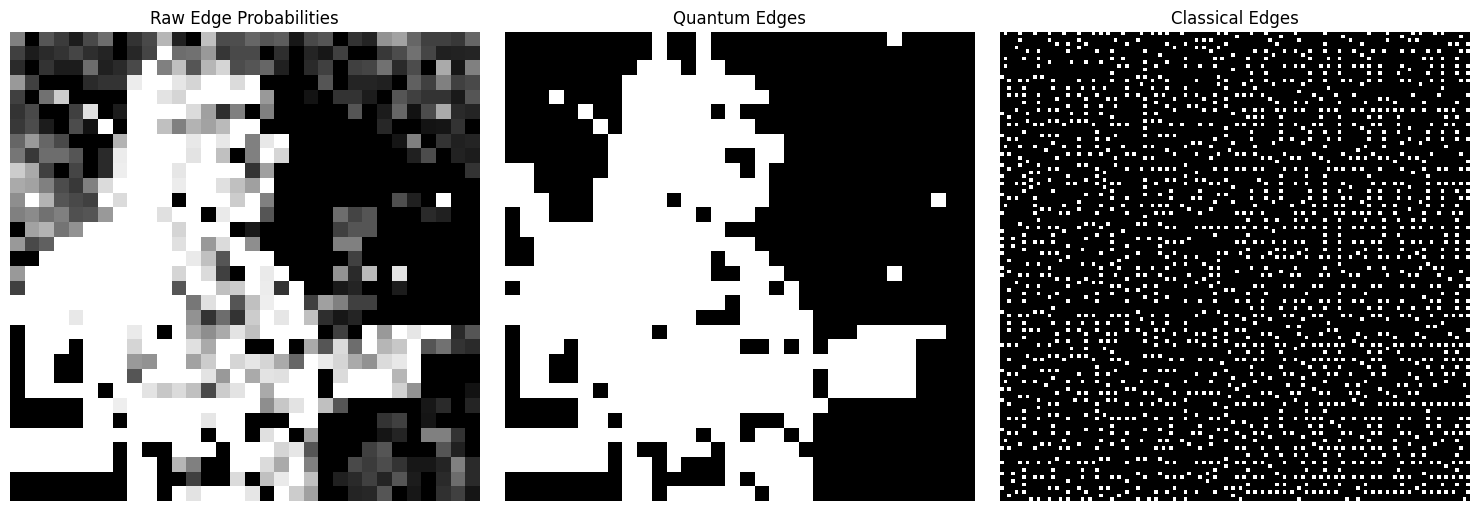

In [7]:
# Replace your Aer simulation cell with:

from qiskit_aer import Aer
from qiskit import QuantumRegister, ClassicalRegister, transpile
from scipy.ndimage import gaussian_filter
import numpy as np

# Quantum registers setup
pos_qubits = 2 * n  # n is your quantum image size
qr_pos = QuantumRegister(pos_qubits, 'pos')
qr_col = QuantumRegister(1, 'color')
cr = ClassicalRegister(pos_qubits+1, 'c')
qc2 = QuantumCircuit(qr_pos, qr_col, cr)
flat_arr = arr.flatten()
# Initialize position register
qc2.h(qr_pos)
qc2.barrier()

ctrl_strings = []
flip_indices = []
pos_qubits = 2 * n
ctrl_strings = [format(i, f'0{pos_qubits}b') for i in range(2**pos_qubits)]
flip_indices = [[j for j, bit in enumerate(ctrl_string) if bit == '0'] for ctrl_string in ctrl_strings]

# FRQI encoding with improved angle mapping
for i, pixel_val in enumerate(flat_arr):
    if pixel_val == 0 or pixel_val == 1:
        continue  # Skip trivial rotations
    theta = np.arccos(np.clip(pixel_val, 0, 1))
    angle = 2 * theta
    flips = flip_indices[i]
    for j in flips:
        qc2.x(qr_pos[j])
    qc2.mcry(angle, list(range(pos_qubits)), pos_qubits)
    for j in flips:
        qc2.x(qr_pos[j])


# Measurement
qc2.measure(qr_pos, cr[:pos_qubits])
qc2.measure(qr_col, cr[pos_qubits])

# Simulation with increased shots
backend = Aer.get_backend('aer_simulator')
shots = 8192  # Increased for better statistics
qc2_t = transpile(qc2, backend, optimization_level=3)
job = backend.run(qc2_t, shots=shots)
result = job.result()
counts = result.get_counts()

# Improved measurement processing
edge_img = np.zeros((2**n, 2**n))
total_counts = np.zeros((2**n, 2**n))

for bitstring, count in counts.items():
    bitstring = bitstring.replace(' ', '')
    # Pad bitstring if too short (Qiskit sometimes drops leading zeros)
    if len(bitstring) < pos_qubits + 1:
        bitstring = bitstring.zfill(pos_qubits + 1)
    color_bit = int(bitstring[0])
    pos_bits = bitstring[1:]
    y = int(pos_bits[n:][::-1], 2)
    x = int(pos_bits[:n][::-1], 2)
    if y < 2**n and x < 2**n:
        total_counts[y, x] += count
        if color_bit == 1:
            edge_img[y, x] += count
# Normalize and post-process
edge_prob = np.where(total_counts > 0, edge_img / total_counts, 0)
edge_prob_smooth = gaussian_filter(edge_prob, sigma=0.5)
edges_qsim = (edge_prob_smooth > 0.5).astype(float)

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(edge_prob, cmap='gray')
plt.title('Raw Edge Probabilities')
plt.axis('off')

plt.subplot(132)
plt.imshow(edges_qsim, cmap='gray')
plt.title('Quantum Edges')
plt.axis('off')

plt.subplot(133)
plt.imshow(edges_classical, cmap='gray')
plt.title('Classical Edges')
plt.axis('off')
plt.tight_layout()
plt.show()

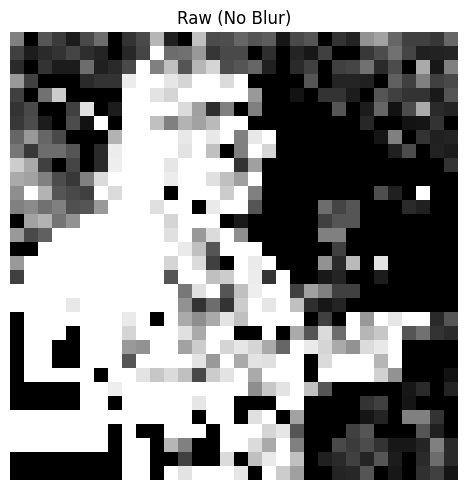

In [8]:

plt.figure(figsize=(20, 5))


plt.imshow(edge_prob, cmap='gray')
plt.title('Raw (No Blur)')
plt.axis('off')

plt.tight_layout()
plt.show()


---

## 1. **Theoretical Quantum Sobel Framework**

### **Quantum Image Representation**
- In FRQI or NEQR, the quantum state encodes all pixel values in superposition.
- For an \(N \times N\) image, you have \(2n\) position qubits and 1 (or more) color qubits.
- The state is:
  \[
  |\psi\rangle = \frac{1}{N} \sum_{i,j} \left( \cos\theta_{ij}|0\rangle + \sin\theta_{ij}|1\rangle \right) |i\rangle|j\rangle
  \]
  where \(\theta_{ij}\) encodes the pixel intensity at position \((i, j)\).

### **Quantum Sobel Operation (Conceptual)**
- **Classically:** For each pixel, Sobel computes a weighted sum of the pixel and its 8 neighbors using the Gx and Gy kernels.
- **Quantumly:** In theory, you could:
  1. **Prepare the image state** (as above).
  2. **For each position \((i, j)\) in superposition:**
      - Use quantum arithmetic to access the amplitudes (pixel values) of \((i, j)\) and its 8 neighbors.
      - Compute the weighted sum (Gx and Gy) using quantum adders and multipliers.
      - Store the result (e.g., as a rotation on an ancilla qubit or as an amplitude).
  3. **Measure** the ancilla or color qubit to extract edge information.

**Challenge:**  
Quantum arithmetic (addition, multiplication, weighted sum) is possible but resource-intensive, especially for large images.

---

## 2. **Role of SVD in Quantum Image Processing**

### **What is SVD?**
- **Singular Value Decomposition** (SVD) factorizes a matrix \(A\) as \(A = U \Sigma V^*\).
- In image processing, SVD is used for compression, denoising, and feature extraction.

### **Quantum SVD**
- Quantum algorithms (like HHL, Quantum PCA, Quantum SVD) can, in principle, extract singular values/vectors exponentially faster for certain matrices.
- **Quantum SVD** could be used to:
  - Compress images quantumly.
  - Extract dominant features (edges, patterns).
  - Preprocess or postprocess quantum images for edge detection.

### **SVD and Edge Detection**
- SVD itself is not an edge detector, but:
  - The largest singular values/vectors often correspond to the most significant features (which may include edges).
  - You could use quantum SVD to preprocess the image, then apply quantum Sobel, or vice versa.
  - SVD can help reduce noise or dimensionality before edge detection.

---

## 3. **Putting It Together: A Theoretical Pipeline**

1. **Quantum Encode** the image (FRQI/NEQR).
2. **(Optional) Quantum SVD** to compress or denoise the image.
3. **Quantum Sobel:**
    - For each pixel (in superposition), use quantum arithmetic to compute the Sobel Gx and Gy.
    - Store the result in an ancilla qubit or as an amplitude.
4. **Measurement:** Extract edge information from the quantum state.

---

## 4. **Why Is This Hard?**

- **Quantum arithmetic** for Sobel is complex and not scalable for large images with current technology.
- **Quantum SVD** requires oracles and is only efficient for certain types of matrices.
- **Quantum memory (QRAM)** is needed for efficient pixel access, which is not yet practical.

---

## 5. **Summary Table**

| Step                | Classical Analog         | Quantum Analog (Theory)                |
|---------------------|-------------------------|----------------------------------------|
| Image storage       | Matrix                  | Quantum state (FRQI/NEQR)              |
| SVD                 | Matrix factorization    | Quantum SVD algorithm                  |
| Sobel edge detect   | Convolution             | Quantum arithmetic on superposition    |
| Edge extraction     | Thresholding, measure   | Quantum measurement                    |

---

## **Conclusion**

- **SVD can play a role** in quantum image processing, especially for compression or feature extraction.
- **Quantum Sobel** is theoretically possible but requires quantum arithmetic and efficient data access.
- **All pixel information is present in the quantum state**, but extracting local (neighbor-based) features quantumly is a major challenge and active research area.

---

